# Cursive Handwriting OCR

In [38]:
import numpy as np
import cv2 # OpenCV
import matplotlib
import matplotlib.pyplot as plt
import collections
import math
import os
import random
import shutil

from scipy import ndimage
from PIL import Image
# iscrtavanje slika u notebook-u
%matplotlib inline
# prikaz vecih slika
matplotlib.rcParams['figure.figsize'] = 16,12
# keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout

from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory

In [39]:
# Marija
# Utility funkcije

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def display_image(image, color=False):
    if color:
        plt.figure()
        plt.imshow(image)
    else:
        plt.figure()
        plt.imshow(image, 'gray')

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):                                                    # gs -> gray scale
    height, width = image_gs.shape[0:2]                                     # [0,2] uzimamo prve dve vrednosti -> visinu i sirinu
    
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin

def invert(image):
    return 255-image

def invert_bin(image):
    return cv2.bitwise_not(image)

def dilate(image):                                                          # prosiruje bele delove slike
    kernel = np.ones((3, 3))                                                # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):                                                           # smannjuje bele delove slike
    kernel = np.ones((3, 3))                                                # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def open(image):                                                            #otvaranje = erozija + dilacija
    return erode(dilate(image))                                             #uklanjanje šuma erozijom i vraćanje originalnog oblika dilacijom

def close(image):                                                           #zatvaranje = dilacija + erozija,
    return dilate(erode(image))                                             #zatvaranje sitnih otvora među belim pikselima

def resize_region(region):
    return cv2.resize(region, (64, 64), interpolation=cv2.INTER_NEAREST)

def matrix_to_vector(image):                                                #pretvara sliku u vektoru
    return image.flatten()

def scale_to_range(image):                                                  #skalira boje sa opsega [0, 255] na [0, 1]   
    return image/255


In [40]:
# Nenad
# Ćelija u kojoj se nalazi kod koji se koristi za spajanje ROI koji se nalaze na trening podacima

def select_roi_training(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        region = image_bin[y:y+h+1, x:x+w+1]
        if region is not None:
            regions_array.append([resize_region(region), (x, y, w, h)])

    # Konture koje sadrze kukice
    connected_regions = [] 
    # Prolazimo kroz niz i proveravamo da li u ostatku niza postoji neki region iznad ili ispod trenutnog i ako 
    # postoji takav region, pravimo jedan veci region oko njih i dodajemo ga
    for region1, (x1, y1, w1, h1) in regions_array:
        for _region2, (x2, y2, w2, h2) in regions_array:
            # Provera da li je isti region
            if (x1, y1, w1, h1) == (x2, y2, w2, h2):
                continue
            mid_x2 = x2 + w2 // 2

            # Provera da li je region kvacica
            if (y1 >= y2 or y1 <= y2) and mid_x2 >= x1 and mid_x2 <= x1 + w1:
                x_min = min(x1, x2)
                y_min = min(y1, y2)
                x_max = max(x1 + w1, x2 + w2) # Rightmost edge
                y_max = max(y1 + h1, y2 + h2) # Bottommost edge

                # New combined bounding box (x3, y3, w3, h3)
                x3 = x_min
                y3 = y_min
                w3 = x_max - x_min
                h3 = y_max - y_min
                region3 = image_bin[y3:y3+h3, x3:x3+w3]
                connected_regions.append([resize_region(region3), (x3, y3, w3, h3)])

    # Sad cemo proci kroz niz regions_array i videti da li se centar tih objekata nalazi unutar 
    # nekog veceg koji je u connected_regions
    # Filtiramo regione tako da na primer za slovo ž sad imamo 2 regiona u regions_array i 1 veci
    # region u connected_regions
    # Ona 2 regiona ne dodajemo u filtrirane regione dok cemo 1 veci region dodati kasnije
    # Ako se nalazi, preskacemo taj objekat, a ako ne onda ga dodajemo u nov niz
    filtered_regions = []
    for region1, (x1, y1, w1, h1) in regions_array:
        mid_x1 = x1 + w1 // 2
        mid_y1 = y1 + h1 // 2
        is_in = False
        for _region2, (x2, y2, w2, h2) in connected_regions:
            if mid_x1 >= x2 and mid_x1 <= x2 + w2 and mid_y1 >= y2 and mid_y1 <= y2 + h2:
                is_in = True
        if not is_in:
            filtered_regions.append([region1, (x1, y1, w1, h1)])
    
    # Dodajemo i one velike regione u kojem su slova sa kukicama
    filtered_regions += connected_regions

    # Iscrtavamo sve te regione
    for _, (x, y, w, h) in filtered_regions:
        cv2.rectangle(image_orig, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
    # Sortiramo niz u kojem su elementi [region, koordinate] po x koordinati
    filtered_regions = sorted(filtered_regions, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in filtered_regions]

    if len(sorted_regions) == 0:
        return image_orig, image_bin
    else:
        return image_orig, sorted_regions

In [41]:
# Marija

def create_ann(output_size):                                        #pravljenje neuronske mreze
    model = Sequential()
    
    # Dublja CNN za rukopis
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):                                       #u sustini a je [1 0 0 ... ], b je [0, 1, 0..]
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))                            #napravimo niz nula
        output[index] = 1                                           #na redni broj slova u alfabetu ide 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def train_ann(ann, train, validation, epochs):

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
    
    print("\nTraining started...")
    history = ann.fit(train, epochs=epochs, verbose=1, validation_data=validation, callbacks=callbacks)
    print("\nTraining completed...")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    return ann

def winner(output):                                                                    # odredjuje pobednicki neuron, onaj  neuron
    return max(enumerate(output), key=lambda x: x[1])[0]                               # cija je aktivaciona vrednost najveca

def display_result_with_spaces(outputs, alphabet, k_means):                                                          
    w_space_group = max(enumerate(k_means.cluster_centers_), key=lambda x: x[1])[0]    # odredjuje rastojanje izmedju reci (max)
                                                                                       # enumerate daje parove
    result = alphabet[winner(outputs[0])]
                                                                                                                        
    for idx, output in enumerate(outputs[1:, :]):
        if k_means.labels_[idx] == w_space_group:
            result += ' '
        result += alphabet[winner(output)]
    return result

In [42]:
# Nenad
# Ćelija u kojoj se nalazi algoritam za rotiranje slike

def rotate_image_to_normal(image, image_grayscale):
    image_edges = cv2.Canny(image_grayscale, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(image_edges, 1, math.pi / 180.0, 100, maxLineGap=5)

    angles = []

    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)
    
    median_angle = np.median()
    image_rotated = ndimage.rotate(image, median_angle)

    return image_rotated

In [43]:
# Marija

def order_points(pts):                                                                                 # pomoćna funkcija, biće potrebna za correct_skewed_image
    rect = np.zeros((4, 2), dtype="float32")                                                           

    s = pts.sum(axis=1)                                                                               
    rect[0] = pts[np.argmin(s)]                                                                         # top-left (najmanji zbir x + y)
    rect[2] = pts[np.argmax(s)]                                                                         # bottom-right (najveći zbir x + y)

    diff = np.diff(pts, axis=1)                                                                        
    rect[1] = pts[np.argmin(diff)]                                                                      # top-right (najmanja razlika x - y)
    rect[3] = pts[np.argmax(diff)]                                                                      # bottom-left (najveća razlika x - y)

    return rect

def image_gray(image):                                                                                 # helper funkcija za konverziju u grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def correct_skewed_image(image):                                                                       # ispravlja slike slikane pod nekim uglom
    gray = image_gray(image)                                                                           
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)                                                         # blurujem da bih smanjila šum i lakše prepoznala ivice
    edges = cv2.Canny(blurred, 50, 150)                                                                 # detekcija ivica pomoću Canny algoritma

    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)                      
    contours = sorted(contours, key=cv2.contourArea, reverse=True)                                     # sortira konture od najveće do najmanje površine

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)                  # uprošćava se kontura
        if len(approx) == 4:
            screen_cnt = approx
            break
    else:
        return image                                                                                    # ako ne nađe konture, vrati original

    rect = order_points(screen_cnt.reshape(4, 2))                                                       # uredimo tačke
    (tl, tr, br, bl) = rect

    width_a = np.linalg.norm(br - bl)                                                                   # donja ivica
    width_b = np.linalg.norm(tr - tl)                                                                   # gornja ivica
    max_width = max(int(width_a), int(width_b))                                                         # širina ispravljene slike

    height_a = np.linalg.norm(tr - br)                                                                  
    height_b = np.linalg.norm(tl - bl)                                                                  
    max_height = max(int(height_a), int(height_b))                                                      # visina ispravljene slike

    dst = np.array([
        [0, 0],                                                                                          # gornji levi ugao
        [max_width - 1, 0],                                                                             # gornji desni
        [max_width - 1, max_height - 1],                                                                # donji desni
        [0, max_height - 1]                                                                             # donji levi
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)                                                          
    warped = cv2.warpPerspective(image, M, (max_width, max_height))                                    # slika se ispravlja

    return warped                                                                                       # vraćamo ispravljenu sliku


In [44]:
# Nenad
# ISTA CELIJA KAO ZA Z2V5 
# Ideja za resenje:
# Priprema za algoritam:
# 1. Neophodno je uraditi selekciju ROI tako da se upamte centri svih kontura u jednom nizu kao i pravougaonici oko kontura
# (2.) Eventualno se mogu upamtiti i visine svih karaktera zbog koraka 2 u algoritmu, to ipak nije uradjeno
# Obrada red po red po sledecim pravilima:
# 1. Uzeti minimalnu y-vrednost centra karaktera u samom nizu centara i izdvojiti ga u poseban niz i obrisati iz trenutnog
# 2. Proci kroz ostatak niza i proveriti da li postoje karakteri sa slicnom y-vrednost centra (y-centar + (visina-karaktera / 2 ili prosto 14 ili prosecna-visina-svih-karaktera / 2)) i dodati ih u poseban niz i obrisati iz trenutnog
# 3. Sortirati poseban niz po x-vrednosti centara i sracunati udaljenosti izmedju svaka 2 karaktera kako bismo mogli uraditi KMeans nad ovim redom
# 4. Prikazemo rezultat samo tog jednog reda sa razmacima i dodamo '\n' na kraj rezultata
# 5. Ponavljamo korake 1-4 sve dok ne dobijemo prazan red centara
# Imas claude i gpt odgovor na ovo :3

# Ideja za verziju 2
# Implementirati isto kao i sto je radjeno sa razmacima ali upotrebom DBSCAN algoritma

# Za detaljno objasnjenje posetiti sajt koji je preporucen za Non-Maximum Suppresion
# https://pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]
				# loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]

def select_roi_test(image_orig, image_bin):
	contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	sorted_regions = [] # lista sortiranih regiona po X osi
	regions_array = []
	for contour in contours:
		x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
		# kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
		# oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
		region = image_bin[y:y+h+1, x:x+w+1]
		regions_array.append([resize_region(region), (x, y, w, h)])

	#
	#
	# ---------- DEO KOJI JE ISTI KAO ONAJ ZA KVACICE ----------
	#
	#
	# Konture koje sadrze kukice
	connected_regions = [] 
	# Prolazimo kroz niz i proveravamo da li u ostatku niza postoji neki region iznad ili ispod trenutnog i ako 
	# postoji takav region, pravimo jedan veci region oko njih i dodajemo ga
	for region1, (x1, y1, w1, h1) in regions_array:
		for _region2, (x2, y2, w2, h2) in regions_array:
			# Provera da li je isti region
			if (x1, y1, w1, h1) == (x2, y2, w2, h2):
				continue
			mid_x2 = x2 + w2 // 2

            # Provera da li je region kvacica
			if (y1 >= y2 or y1 <= y2) and mid_x2 >= x1 and mid_x2 <= x1 + w1:
				x_min = min(x1, x2)
				y_min = min(y1, y2)
				x_max = max(x1 + w1, x2 + w2) # Rightmost edge
				y_max = max(y1 + h1, y2 + h2) # Bottommost edge

				# New combined bounding box (x3, y3, w3, h3)
				x3 = x_min
				y3 = y_min
				w3 = x_max - x_min
				h3 = y_max - y_min
				region3 = image_bin[y3:y3+h3, x3:x3+w3]
				
				connected_regions.append([resize_region(region3), (x3, y3, w3, h3)])

	# Sad cemo proci kroz niz regions_array i videti da li se centar tih objekata nalazi unutar 
	# nekog veceg koji je u connected_regions
	# Filtiramo regione tako da na primer za slovo ž sad imamo 2 regiona u regions_array i 1 veci
	# region u connected_regions
	# Ona 2 regiona ne dodajemo u filtrirane regione dok cemo 1 veci region dodati kasnije
	# Ako se nalazi, preskacemo taj objekat, a ako ne onda ga dodajemo u nov niz
	filtered_regions = []
	for region1, (x1, y1, w1, h1) in regions_array:
		mid_x1 = x1 + w1 // 2
		mid_y1 = y1 + h1 // 2
		is_in = False
		for _region2, (x2, y2, w2, h2) in connected_regions:
			if mid_x1 >= x2 and mid_x1 <= x2 + w2 and mid_y1 >= y2 and mid_y1 <= y2 + h2:
				is_in = True
		if not is_in:
			filtered_regions.append([region1, (x1, y1, w1, h1)])
    
    # Dodajemo i one velike regione u kojem su slova sa kukicama
	filtered_regions += connected_regions
	#
	#
	# ---------- KRAJ DELA KOJI JE ISTI KAO ONAJ ZA KVACICE ----------
	#
	#

	regions_array = filtered_regions
	# Pripremamo podatke za NMS funkciju jer ona uzima podatke u obliku [x1, y1, x2, y2] (gornje levo teme i donje desno teme pravougaonika)
	# Dok mi radimo ovde samo sa (y1, x1) <- dovoljno je znati samo gornje levo teme jer znamo da su svi auti dimenzija 100x40 (width x height)
	boundingBoxes = np.zeros((len(regions_array), 4))
	for i in range(len(regions_array)):
		x, y, w, h = regions_array[i][1]
		boundingBoxes[i] = [x, y, x + w, y + h]

	# Primenjujemo NMS
	boundingBoxes = non_max_suppression_slow(boundingBoxes, 0.3)
	# Vracamo podatke u oblik [x, y, w, h]
	boundingBoxes = [[x1, y1, x2 - x1, y2 - y1] for (x1, y1, x2, y2) in boundingBoxes]

	# Pravimo skup od tih podataka, u skupu se nalaze samo x vrednosti koordinata
	bounding_box_set = set(box[0] for box in boundingBoxes)
	# Filtriramo regions_array kako bismo samo zadrzali elemente koje nam je NMS vratio
	filtered_regions = [
        item for item in regions_array 
        if item[1][0] in bounding_box_set
    ]

	# Iscrtavamo pravougaonike oko svakog od filtriranih regiona
	for _, (x,y,w,h) in filtered_regions:
		cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)

	# Sortiramo filtrirane regione
	filtered_regions = sorted(filtered_regions, key=lambda x: x[1][0])

	# Izdvajamo same regione
	sorted_regions = [region[0] for region in filtered_regions]

	# Izdvajamo centre regione u oblik (x_centar, y_centar)
	regions_centers = [] # lista centara samih karaktera
	regions_centers = [(region[1][0] + region[1][2] // 2, region[1][1] + region[1][3] // 2) for region in filtered_regions]
	
	# Izdvajamo [x, y, w, h] iz regiona
	sorted_rectangles = [region[1] for region in filtered_regions]
	return image_orig, sorted_regions, regions_centers, sorted_rectangles

In [45]:
# Kod koji se koristi za preprocesiranje trening skupa

def convert_transparent_to_white_bg(input_folder, output_folder):
    """Convert transparent PNGs to white background"""
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path).convert("RGBA")
            
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[-1]) 

            img_cv = cv2.cvtColor(np.array(background), cv2.COLOR_RGB2BGR)
            img_gray = image_gray(img_cv)
            img_bin = image_bin(img_gray)
            img_bin = invert_bin(img_bin)
            _, img_bin = select_roi_training(img_cv, img_bin)
            
            if img_bin:
                first_region_image = img_bin[0]
                first_region_image = invert_bin(first_region_image)
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, first_region_image)
                print("Processed: ", output_path)

if 'train_processed' not in os.listdir('../data/'):
    for foldername in os.listdir('../data/train/'):
        if foldername not in os.listdir('../data/'):
            os.makedirs('../data/train_processed/' + foldername)

        convert_transparent_to_white_bg('../data/train/' + foldername + '/', '../data/train_processed/' + foldername + '/')
else:
    print('Data has already been preprocessed!')

Data has already been preprocessed!


In [46]:
# Nenad
# Ćelija koja se koristi za kreiranje validacionih podataka na osnovu trening skupa

def pick_random_files(directory, count=3):
    all_items = os.listdir(directory)
    files = [f for f in all_items if os.path.isfile(os.path.join(directory, f))]
    
    if len(files) >= count:
        random_files = random.sample(files, count)
        return random_files
    else:
        return files
    
def create_validation_folder(training_folder, validation_folder):
    for character_name in os.listdir(training_folder):
        # Ako već postoji validacioni folder, onda nastavljamo na sledeći karakter
        if character_name in os.listdir(validation_folder):
            continue
        
        current_images_folder = training_folder + character_name + '/'
        new_validation_folder = validation_folder + character_name
        os.makedirs(new_validation_folder)  
        new_validation_folder += '/'

        files = pick_random_files(current_images_folder, count=3)
        for file in files:
                source_path = os.path.join(current_images_folder, file)
                destination_path = os.path.join(new_validation_folder, file)
                shutil.copy2(source_path, destination_path)

if 'val' not in os.listdir('../data/'):
    os.makedirs('../data/val')
    validation_folder = '../data/val/'
    training_folder = '../data/train_processed/'
    create_validation_folder(training_folder, validation_folder)
    print("Succesfully created validation set!")
else:
    print("Validation set already exists!")

Validation set already exists!


In [47]:
# Nenad
# Sad ide pravi test :)

def extract_text(image, model_nn, alphabet):
    # Ovde ce biti rezultat
    test_result = ''
    # Ucitamo sliku
    test_color = image.copy()
    test = image_bin(image_gray(test_color))
    test_bin = dilate(erode(test))

    # Oznacavamo ROI i prikazujemo sliku
    selected_test, sorted_regions, regions_centers, sorted_rectangles = select_roi_test(test_color.copy(), test_bin)
    display_image(selected_test)

    # Pravimo temp jer cemo iz njega u algoritmu brisati elemente 
    sorted_regions_temp = sorted_regions.copy()

    while len(regions_centers) > 0:
        # 1. Uzeti minimalnu y-vrednost centra karaktera u samom nizu centara i izdvojiti ga u poseban niz i obrisati iz trenutnog
        minv = min(regions_centers, key=lambda x: x[1])
        # Nabavljamo indeks minimalnog kako bismo znali sa kog indeksa brisemo u drugim nizovima
        minv_ind = regions_centers.index(minv)

        simillar_center = [regions_centers[minv_ind]]
        sorted_regions_row = [sorted_regions_temp[minv_ind]]
        sorted_rectangles_row = [sorted_rectangles[minv_ind]]

        # Brisanje elementa iz nizova
        regions_centers.remove(minv)
        del sorted_regions_temp[minv_ind]
        del sorted_rectangles[minv_ind]

        # 2. Proci kroz ostatak niza i proveriti da li postoje karakteri sa slicnom y-vrednost centra (y-centar + (visina-karaktera / 2 ili prosto 14 ili prosecna-visina-svih-karaktera / 2)) 
        # i dodati ih u posebne nizove i obrisati iz trenutnih nizova
        simillar_center += [x for x in regions_centers if x[1] >= minv[1] - 14 and x[1] <= minv[1] + 14]
        for x in simillar_center:
            if x in regions_centers:
                ind = regions_centers.index(x)
                regions_centers.remove(x)
                sorted_regions_row += [sorted_regions_temp[ind]]
                sorted_rectangles_row += [sorted_rectangles[ind]]
                del sorted_regions_temp[ind]
                del sorted_rectangles[ind]

        # Korisceno da vidim da li sve radi kako sam zeleo :)
        #print(len(regions_centers), len(sorted_regions_temp), len(sorted_rectangles))
        #print(len(simillar_center), len(sorted_regions_row), len(sorted_rectangles_row))

        # 3. Sortirati poseban niz po x-vrednosti centara i sracunati udaljenosti izmedju svaka 2 karaktera kako bismo mogli uraditi KMeans nad ovim redom
        # Spajamo regione i centre u jedan niz
        sorted_regions_and_centers = []
        for i in range(len(sorted_regions_row)):
            sorted_regions_and_centers += [[sorted_regions_row[i], simillar_center[i]]]

        # Sortiramo niz po x vrednosti i izvlacimo regione i centre u poseban niz
        # Ovaj korak je bio potreban jer nisam bio siguran u to da li ce elementi ocuvati sortiranost iz prethodnih koraka
        sorted_regions_and_centers = sorted(sorted_regions_and_centers, key=lambda x: x[1][0])
        sorted_regions_row = [region[0] for region in sorted_regions_and_centers]
        sorted_centers_row = [region[1] for region in sorted_regions_and_centers]

        # Racunamo distance i primenjujemo KMeans
        region_distances = []
        for index in range(0, len(sorted_rectangles_row) - 1):
            current = sorted_rectangles_row[index]
            next_rect = sorted_rectangles_row[index + 1]
            distance = next_rect[0] - (current[0] + current[2]) # x_next - (x_current + w_current)
            region_distances.append(distance)

        region_distances = np.array(region_distances).reshape(len(region_distances), 1)
        k_means = KMeans(n_clusters=2, n_init=10)
        k_means.fit(region_distances)

        # 4. Prikazemo rezultat samo tog jednog reda sa razmacima i dodamo '\n' na kraj rezultata
        test_inputs = prepare_for_ann(sorted_regions_row)
        result = model_nn.predict(np.array(test_inputs, np.float32))
        test_result += display_result_with_spaces(result, alphabet, k_means)
        test_result += '\n'
        # 5. Ponavljamo korake 1-4 sve dok ne dobijemo prazan red centara

    return test_result

In [48]:
# Nenad
# Ideja je da folderi se nazivaju po indeksima karaktera koji su u nizu
# Primer: Velika slova B se nalaze u folderu 01, što je indeks tog karaktera u alfabetu
# Kako se budu dodavali karakteri ići će ovako redom:
# 1. Velika slova engleske latinice
# 2. Mala slova engleske latinice
# 3. Velika slova Č, Ć, Đ, Ž i Š 
# 4. Mala slova č, ć, đ, ž i š
# 5. Velika slova ćirilice
# 6. Mala slova ćirilice
# 7. Cifre
# 8. Znakovi interpunkcije

alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
            'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
            ]

alphabet_labels = [ '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0A', '0B', '0C',
                    '0D', '0E', '0F', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'
                  ]

Found 11102 files belonging to 26 classes.
Found 78 files belonging to 26 classes.

Training started...
Epoch 1/5
694/694 [==============================] - 38s 53ms/step - loss: 2.7050 - accuracy: 0.4368 - val_loss: 0.6200 - val_accuracy: 0.8333
Epoch 2/5
694/694 [==============================] - 35s 50ms/step - loss: 0.8044 - accuracy: 0.7641 - val_loss: 0.2481 - val_accuracy: 0.9231
Epoch 3/5
694/694 [==============================] - 36s 52ms/step - loss: 0.5240 - accuracy: 0.8543 - val_loss: 0.1221 - val_accuracy: 0.9744
Epoch 4/5
694/694 [==============================] - 35s 50ms/step - loss: 0.3907 - accuracy: 0.8890 - val_loss: 0.0654 - val_accuracy: 0.9872
Epoch 5/5
694/694 [==============================] - 35s 51ms/step - loss: 0.3122 - accuracy: 0.9110 - val_loss: 0.0995 - val_accuracy: 0.9615

Training completed...


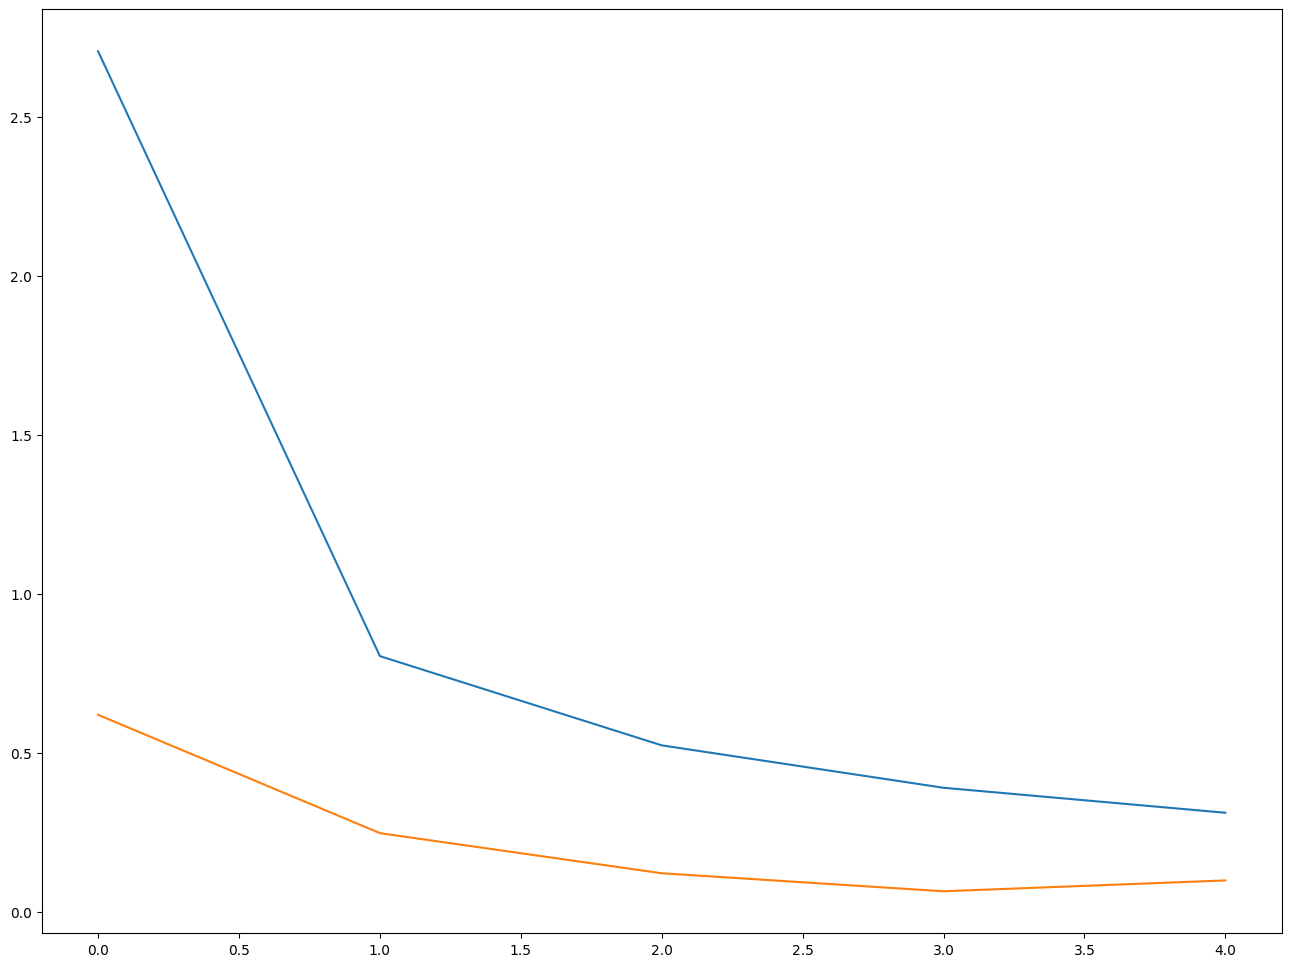

In [49]:
train_dataset = image_dataset_from_directory(
    '../data/train_processed/',
    batch_size=16,
    color_mode='grayscale',
    image_size=(64, 64),
    label_mode='categorical'
)

validation_dataset = image_dataset_from_directory(
    '../data/val/',
    batch_size=16,
    color_mode='grayscale',
    image_size=(64, 64),
    label_mode='categorical'
)

ann = create_ann(output_size=(len(alphabet)))
ann = train_ann(ann, train_dataset, validation_dataset, epochs=5) # smanjeno je na 5 epoha kako ne bih cekao doveka da se utrenira

In [50]:
def hex_to_alphabet(hex_str, alphabet, alphabet_labels):
    result = ""
    i = 0
    while i < len(hex_str):
        char = hex_str[i]

        if char in ['\n', ' ']:
            result += char
            i += 1
        else:
            if i + 1 < len(hex_str):
                hex_code = hex_str[i:i+2]
                
                if hex_code in alphabet_labels:
                    result += alphabet[int(hex_code, 16)]
                    i += 2
                else:
                    result += char
                    i += 1
                
            else:
                result += char
                i += 1
    
    return result

In [ ]:
# Postupak rada nad testnom slikom: 
# 1. Ucita se slika
# 2. Primeni se unskewed metoda
# 3. Primeni se metoda za rotiranje
# 4. Slika se binarizuje
# 5. Slika se posalje na ekstrakciju podataka
# 6. Dobijeni rezultat se preradi na osnovu alfabeta
# 7. Prikaze se konacni rezultat

# Nacin exportovanja modela iz notebook-a je dostupan kod gemini-ja - Nenad
